In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


**Идея для оценки лаговости инструментов**

Мы построим временные ряды по всем инструментам, добавив эти отстающие признаки одного инструментв в другой и возьмем модель, оптимизурующая через веса. Так как сама суть временных рядов подразумевает расчет лаговости для прогнозирования цены. 

Если в оценке одного инструмента веса на признаках другого инструментах высоки, то мы можем утверждать, что допустим рассчитав какие-то время назад на этом инструменте вот эту метрику и дав ему вот такой вес, то можно оценить инструмент, на который эти признаки влияют.

Разобьем данные на инструменты, переведем в 30 минутные свечи, посмотрим графики цен и логарифмическую доходность

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

df = pd.read_csv('/content/drive/MyDrive/ss/qa_futures.csv', index_col=[0], parse_dates=[0])
df.columns = ['close','name']
df['name'].value_counts()

E-MINI S&P 500 FUTURES           672899
FTSE CHINA A50 INDEX FUTURES     565443
10 YEAR TREASURY NOTE FUTURES    518515
Name: name, dtype: int64

In [ ]:
sp500 = df.query('name == "E-MINI S&P 500 FUTURES"').drop(columns=['name'], axis = 1).sort_values(by='Timestamp', ascending = True).copy()
china_a50 = df.query('name == "FTSE CHINA A50 INDEX FUTURES"').drop(columns=['name'], axis = 1).copy().sort_values(by='Timestamp', ascending = True).copy()
treas10 = df.query('name == "10 YEAR TREASURY NOTE FUTURES"').drop(columns=['name'], axis = 1).copy().sort_values(by='Timestamp', ascending = True).copy()

sp500.columns = ['close_sp500']
china_a50.columns = ['close_china']
treas10.columns = ['close_treas']

"""Возьмем 30 минутные свечки, тк в них меньше шума и проще будет ловить лаговость между инструментами"""
sp500 = sp500.resample('30Min').last()
china_a50 = china_a50.resample('30Min').last()
treas10 = treas10.resample('30Min').last()

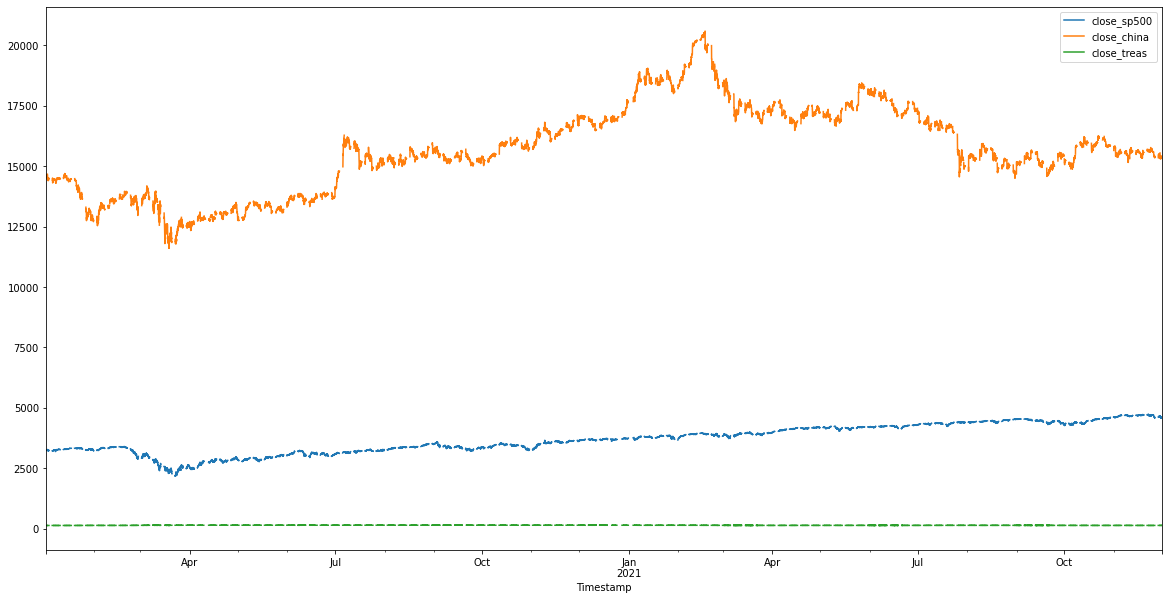

In [ ]:
sp500.join(china_a50).join(treas10).plot(figsize=(20,10))

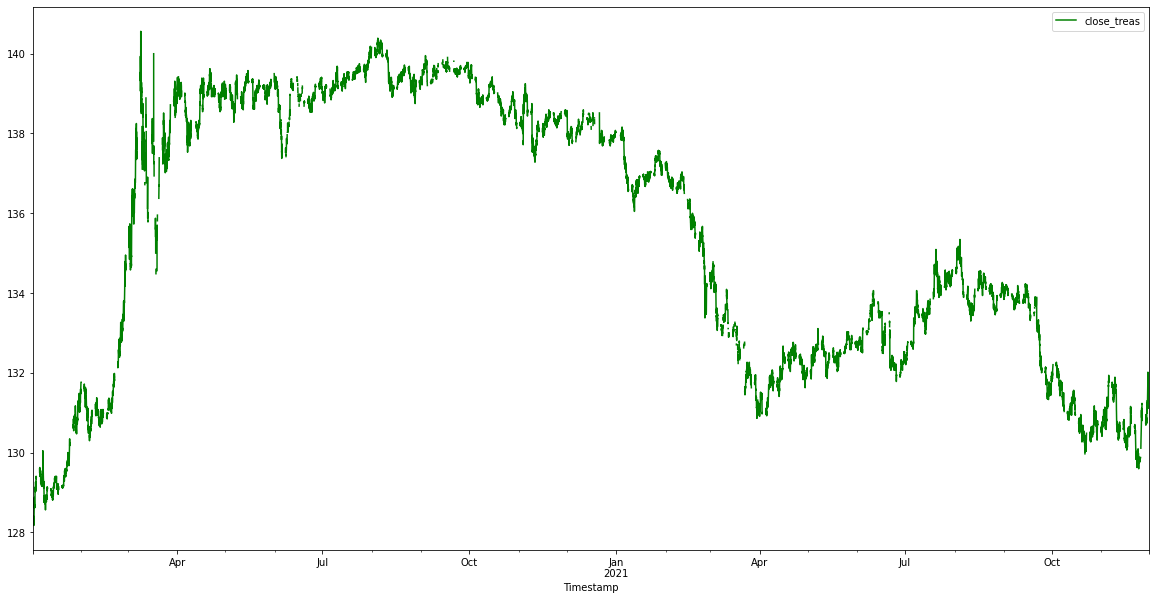

In [ ]:
treas10.plot(figsize=(20,10), color = 'green') 
#Так как цена казначейских облигаций сильно ниже других инструментов, то рассмотрим отдельно тк на графике выше видим прямую линию

Посмотрев в целом динамику цен, не можем пока сказать есть ли какие-то взамосвязи, кроме того, что тренд в целом растущий, но это пока нам не о чем не говорит. 

Посмотрим логарифм доходностей инструментов, тк они будут в единой размерности и с разными диапозанами цен мы будем видеть одинаковые процентные изменения.

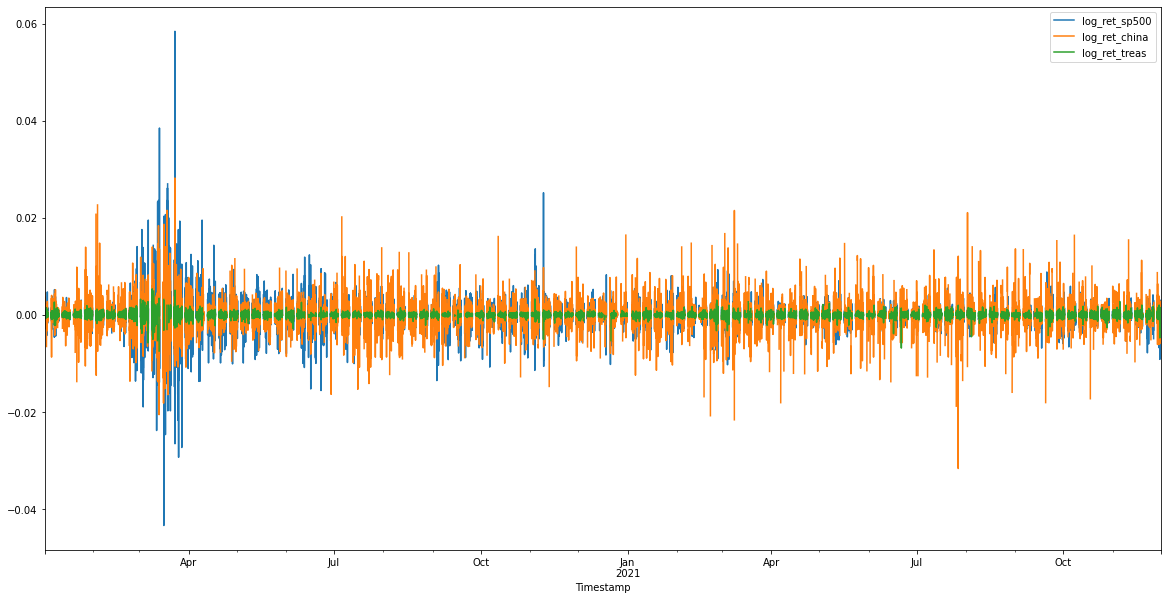

In [ ]:
sp500['log_ret_sp500'] = np.log(sp500.close_sp500) - np.log(sp500.close_sp500.shift(1))
china_a50['log_ret_china'] = np.log(china_a50.close_china) - np.log(china_a50.close_china.shift(1))
treas10['log_ret_treas'] = np.log(treas10.close_treas) - np.log(treas10.close_treas.shift(1))

log_df = sp500.join(china_a50).join(treas10)
log_df[['log_ret_sp500', 'log_ret_china', 'log_ret_treas']].plot(figsize = (20, 10))

Имеем станционарные ряды по всем инструментам после 2020-06, можем предсказывать по методам временных рядов. Создадим лаговые признаки по абсолютным значением и логарифм доходности, убрав шум до 2020-06, где скорее всего пандемия повлияла на увелечение стандартного отклонения.

Пока про лаг зависимости не можем сказать, тк на них могут влиять одинаково сторонние глобальные тренды или признаки

In [ ]:
#Уберем шум

sp500 = sp500['2020-07-01 00:00:00':].copy()
china_a50 = china_a50['2020-07-01 00:00:00':].copy()
treas10 = treas10['2020-07-01 00:00:00':].copy()

In [ ]:
#Cоздадим функцию, которая позволит выбирать кол-во лагов и взвешенное скользящее среднее, как менее запаздавающее, чем обычное скользящее среднее

def features(data, max_lag, wma_period, close = 'close', log_ret = 'log_ret', lag_log = 'lag_log_{}', lag_abs = 'lag_{}', wma = 'wma'):

    for lag in range(1, max_lag + 1):
        data[lag_log.format(lag)] = data[log_ret].shift(lag)

    for lag in range(1, max_lag + 1):
        data[lag_abs.format(lag)] = data[close].shift(lag)

    data[wma] = data[close].shift().rolling(wma_period).apply(lambda x: ((np.arange(wma_period)+1)*x).sum()/(np.arange(wma_period)+1).sum())

In [ ]:
max_lag = 10
wma_period = 10

features(sp500, max_lag, wma_period, 'close_sp500', 'log_ret_sp500', 'lag_log_sp500_{}', 'lag_sp500_{}', 'wma_sp500')
features(china_a50, max_lag, wma_period, 'close_china', 'log_ret_china', 'lag_log_china_{}', 'lag_china_{}', 'wma_china')
features(treas10, max_lag, wma_period, 'close_treas', 'log_ret_treas', 'lag_log_treas_{}', 'lag_treas_{}', 'wma_treas')

In [ ]:
sp500 = sp500.dropna()
china_a50 = china_a50.dropna()
treas10 = treas10.dropna()


#Уберем текущие лог доходности, дабы не было зазора в будушее

sp500 = sp500.drop('log_ret_sp500', axis=1)
china_a50 = china_a50.drop('log_ret_china', axis=1)
treas10 = treas10.drop('log_ret_treas', axis=1)

Обучим SP500 и SP500 с китайскими признаками china_a50, если качество модели улучшиться или веса на "китайских" признаках будут внушительны, то мы доказали, что есть лаговость, и эти коеффициенты в модели можно использовать для оценки лаговой зависимости между инструментами

In [ ]:
#SP500

features_train, features_valid, target_train, target_valid = train_test_split(
    sp500.drop('close_sp500', axis=1), sp500.close_sp500, shuffle = False ,test_size=0.2, random_state=12345)

In [ ]:
"""Возьмем ридж-регрессию, как подходящую модель для оценки весов регрессии и регуляризации, которая занизит веса слишком шумным или коррелующим признакам, 
выделяя как раз самые значимые признаки, чтобы доказать лаговость между инструментами"""

model = Ridge(alpha = 1.0)

model.fit(features_train, target_train)
y_pred = model.predict(features_valid)
print("RMSE: ", mean_squared_error(target_valid, y_pred, squared = False))
print("R2: ", r2_score(target_valid, y_pred))

RMSE:  5.2448191416907095
R2:  0.9980517279052997


In [ ]:
#Добавим признаки китайского фьючерса для прогноза sp500

sp_china = sp500.join(china_a50).copy()
sp_china = sp_china.drop('close_china', axis=1)
sp_china = sp_china.dropna()

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    sp_china.drop('close_sp500', axis=1), sp_china.close_sp500, shuffle = False , test_size=0.2, random_state=12345)

model.fit(features_train, target_train)
y_pred = model.predict(features_valid)
print("RMSE: ", mean_squared_error(target_valid, y_pred, squared = False))
print("R2: ", r2_score(target_valid, y_pred))

RMSE:  5.563967533138431
R2:  0.9978091540790905


In [ ]:
#Создадим таблицу весов и посмотрим, насколько сильно повлияли признаки с китайского фьючерса

coef_table = pd.DataFrame(list(features_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model.coef_.transpose())
coef_table.sort_values(by='Coefs', ascending=False).reset_index(drop=True)

,0,Coefs
0,lag_sp500_1,0.978892
1,lag_log_china_10,0.554522
2,wma_sp500,0.161675
3,lag_log_sp500_2,0.117655
4,lag_log_sp500_6,0.066946
5,lag_log_china_2,0.055955
6,lag_log_sp500_1,0.055773
7,lag_sp500_5,0.022905
8,lag_sp500_7,0.016487
9,lag_log_china_1,0.016267


Есть хороший вес на 10 лог лаговости и 2 лог лаговости. То есть логарифм доходности 6 часов и час назад влияют на цену sp500.

Качество модели особо не поменялось, но выделила "китайские" признаки как важные по весам

**Посмотрим аналогично с SP500 и 10 летние облигации США**

In [ ]:
sp_treas = sp500.join(treas10).copy()
sp_treas = sp_treas.drop('close_treas', axis=1)
sp_treas = sp_treas.dropna()

features_train, features_valid, target_train, target_valid = train_test_split(
    sp_treas.drop('close_sp500', axis=1), sp_treas.close_sp500, shuffle = False , test_size=0.2, random_state=12345)

model.fit(features_train, target_train)
y_pred = model.predict(features_valid)
print("RMSE: ", mean_squared_error(target_valid, y_pred, squared = False))
print("R2: ", r2_score(target_valid, y_pred))

RMSE:  5.196800769155541
R2:  0.9982578208575208


In [ ]:
coef_table = pd.DataFrame(list(features_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model.coef_.transpose())
coef_table.sort_values(by='Coefs', ascending=False).reset_index(drop=True)

,0,Coefs
0,lag_treas_3,4.009134
1,lag_sp500_1,0.962268
2,lag_treas_9,0.906559
3,lag_treas_6,0.737941
4,lag_log_treas_10,0.217001
5,wma_sp500,0.160973
6,lag_log_sp500_1,0.088960
7,lag_log_sp500_2,0.088026
8,lag_log_sp500_6,0.061808
9,wma_treas,0.039003


Тут мы видим как цены 10 летних облигаций на лаг 3 (то есть 90 мин назад), лаг 6 и лаг 9, то есть по полтора часа еще назад влияют на цену фьючерса SP500.

А тут качество модели уже улучшилось, что показывает хорошую взаимосвязь этих инструментов

**Тест на 10 летние облигации США и китайский фьючерс**

In [ ]:
china_treas = treas10.join(china_a50).copy()
china_treas = china_treas.drop('close_china', axis=1)
china_treas = china_treas.dropna()

features_train, features_valid, target_train, target_valid = train_test_split(
    china_treas.drop('close_treas', axis=1), china_treas.close_treas, shuffle = False , test_size=0.2, random_state=12345)

model.fit(features_train, target_train)
y_pred = model.predict(features_valid)
print("RMSE: ", mean_squared_error(target_valid, y_pred, squared = False))
print("R2: ", r2_score(target_valid, y_pred))

RMSE:  0.0620704437974695
R2:  0.9977283873795327


In [ ]:
coef_table = pd.DataFrame(list(features_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",model.coef_.transpose())
coef_table.sort_values(by='Coefs', ascending=False).reset_index(drop=True)

,0,Coefs
0,lag_treas_1,8.738956e-01
1,wma_treas,1.592695e-01
2,lag_treas_2,7.576217e-02
3,lag_treas_9,1.316279e-02
4,lag_treas_4,1.307149e-02
5,lag_log_treas_1,5.940109e-03
6,lag_log_treas_10,3.782726e-03
7,lag_log_china_9,9.418029e-04
8,lag_log_treas_2,9.136402e-04
9,lag_log_china_4,6.903384e-04


Тут лаговости особо нет между этими инструментами, ближайший китайский признак на 7 месте, поэтому не можем сказать, что валидно будет использовать эту взаимосвязь

**Вывод**

Так как китайский фьючерс торгуется раньше, чем американский, то видим, что есть хорошая лаг связь с SP500, но недостаточная с 10 летними облигациями

Так же есть хорошая лаг связь с SP500 и 10 летними облигациями.

В обоих случаях можно рассчитывать эти признаки и зная веса примерно оценить в каком направлении и через какое время двинется инструмент